In [1]:
import cv2
import glob
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split

%matplotlib inline

# Process and Store Images to a database

In [ ]:
FILE_PATH_PARASITIZED = "datasets\\Archived\\Parasitized\\"
FILE_PATH_UNINFECTED = "datasets\\Archived\\Uninfected\\"

In [ ]:
parasitized = glob.glob(FILE_PATH_PARASITIZED + "*.png")
uninfected = glob.glob(FILE_PATH_UNINFECTED + "*.png")

In [ ]:
x_list = []
y_list = []

for image in parasitized:
    img = cv2.imread(image)
    res = cv2.resize(img, dsize=(32,32))
    x_list.append(res)
    y_list.append(1)
    
for image in uninfected:
    img = cv2.imread(image)
    res = cv2.resize(img, dsize=(32,32))
    x_list.append(res)
    y_list.append(0)
    
x = np.array(x_list)
y = np.array(y_list)

x = x/255.
y = y.reshape((y.shape[0],1))

print("x.shape: %s" % str(x.shape))
print("y.shape: %s" % str(y.shape))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [ ]:
hf_train = h5py.File("train_malaria.h5", "w")
hf_train.create_dataset("train_set_x", data=X_train)
hf_train.create_dataset("train_set_y", data=y_train)
hf_train.close()

hf_test = h5py.File("test_malaria.h5", "w")
hf_test.create_dataset("test_set_x", data=X_test)
hf_test.create_dataset("test_set_y", data=y_test)
hf_test.close()

# Loading Data

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_malaria.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_malaria.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [3]:
X_train, Y_train, X_test, Y_test = load_dataset()

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

print(X_train.shape)
print(Y_train.shape)

print(X_dev.shape)
print(Y_dev.shape)

print(X_test.shape)
print(Y_test.shape)

(18463, 32, 32, 3)
(18463, 1)
(4547, 32, 32, 3)
(4547, 1)
(4548, 32, 32, 3)
(4548, 1)


# Creating the Network

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(4,4), strides=1, padding="same", activation=tf.nn.relu, input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=8, padding="same"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=4, padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])  

In [32]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [33]:
model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
18463/18463 [==============================] - 13s 706us/sample - loss: 0.0872 - acc: 0.9687 - loss: 0
Epoch 2/100
18463/18463 [==============================] - 13s 730us/sample - loss: 0.0869 - acc: 0.9700 - loss: 0.0873 - acc: 0.9
Epoch 3/100
18463/18463 [==============================] - 14s 743us/sample - loss: 0.0885 - acc: 0.9679
Epoch 4/100
18463/18463 [==============================] - 14s 750us/sample - loss: 0.0859 - acc: 0.9698
Epoch 5/100
18463/18463 [==============================] - 14s 783us/sample - loss: 0.0861 - acc: 0.9691 - l
Epoch 6/100
18463/18463 [==============================] - 15s 795us/sample - loss: 0.0871 - acc: 0.9687 - loss: 0.0871 - acc: 0.968
Epoch 7/100
18463/18463 [==============================] - 15s 799us/sample - loss: 0.0876 - acc: 0.9684
Epoch 8/100
18463/18463 [==============================] - 15s 803us/sample - loss: 0.0858 - acc: 0.9699
Epoch 9/100
18463/18463 [==============================] - 15s 799us/sample - loss: 0.0865 -

18463/18463 [==============================] - 15s 791us/sample - loss: 0.0800 - acc: 0.9707
Epoch 78/100
18463/18463 [==============================] - 15s 796us/sample - loss: 0.0794 - acc: 0.9723
Epoch 79/100
18463/18463 [==============================] - 15s 804us/sample - loss: 0.0799 - acc: 0.9716
Epoch 80/100
18463/18463 [==============================] - 15s 789us/sample - loss: 0.0791 - acc: 0.9721
Epoch 81/100
18463/18463 [==============================] - 15s 807us/sample - loss: 0.0800 - acc: 0.9715
Epoch 82/100
18463/18463 [==============================] - 15s 800us/sample - loss: 0.0780 - acc: 0.9722
Epoch 83/100
18463/18463 [==============================] - 15s 802us/sample - loss: 0.0779 - acc: 0.9725
Epoch 84/100
18463/18463 [==============================] - 15s 788us/sample - loss: 0.0793 - acc: 0.9720
Epoch 85/100
18463/18463 [==============================] - 15s 795us/sample - loss: 0.0789 - acc: 0.9718
Epoch 86/100
18463/18463 [==============================] -

In [34]:
dev_loss, dev_acc = model.evaluate(X_dev, Y_dev)

print('Dev set accuracy:', dev_acc)

4547/4547 [==============================] - 2s 371us/sample - loss: 0.1534 - acc: 0.9514
Dev set accuracy: 0.9513965


In [35]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('Test set accuracy:', test_acc)

4548/4548 [==============================] - 2s 425us/sample - loss: 0.1461 - acc: 0.9598
Test set accuracy: 0.9597625


[ True]


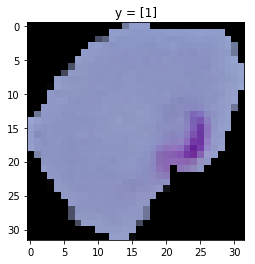

In [36]:
index = 999
predictions = model.predict(X_test) > 0.5
print(predictions[index])
plt.title("y = %s" % Y_test[index])
plt.imshow(X_test[index])